<a href="https://colab.research.google.com/github/Shideh-kadkhodaei/us-accidents/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shidehkadkhodaei","key":"d420308f45b197512727f8232716ce75"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d sobhanmoosavi/us-accidents

Dataset URL: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents
License(s): CC-BY-NC-SA-4.0
 97% 634M/653M [00:01<00:00, 282MB/s]
100% 653M/653M [00:01<00:00, 377MB/s]


In [5]:
!unzip us-accidents.zip

Archive:  us-accidents.zip
  inflating: US_Accidents_March23.csv  


In [6]:
import cudf

df = cudf.read_csv("/content/US_Accidents_March23.csv")
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype
---  ------                 -----
 0   ID                     object
 1   Source                 object
 2   Severity               int64
 3   Start_Time             object
 4   End_Time               object
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object
 11  Street                 object
 12  City                   object
 13  County                 object
 14  State                  object
 15  Zipcode                object
 16  Country                object
 17  Timezone               object
 18  Airport_Code           object
 19  Weather_Timestamp      object
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)            float64
 23  

In [7]:
# Drop rows with missing coordinates
df = df.dropna(subset=['Start_Lat', 'Start_Lng'])

# Keep only valid lat and lon values
df = df[(df['Start_Lat'].between(-90, 90)) & (df['Start_Lng'].between(-180, 180))]

# Display summary statistics
df[['Start_Lat', 'Start_Lng']].describe()

,Start_Lat,Start_Lng
count,7.728394e+06,7.728394e+06
mean,3.620119e+01,-9.470255e+01
std,5.076079e+00,1.739176e+01
min,2.455480e+01,-1.246238e+02
25%,3.339963e+01,-1.172194e+02
50%,3.582397e+01,-8.776662e+01
75%,4.008496e+01,-8.035368e+01
max,4.900220e+01,-6.711317e+01


In [8]:
# Calculate mean and standard deviation for latitude and longitude
lat_mean = df['Start_Lat'].mean()
lat_std = df['Start_Lat'].std()
lng_mean = df['Start_Lng'].mean()
lng_std = df['Start_Lng'].std()

# Identify outliers
outliers = df[
    (abs(df['Start_Lat'] - lat_mean) > 3 * lat_std) |
    (abs(df['Start_Lng'] - lng_mean) > 3 * lng_std)
]

# Show first few outliers
outliers[['Start_Lat', 'Start_Lng']].head()

,Start_Lat,Start_Lng


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


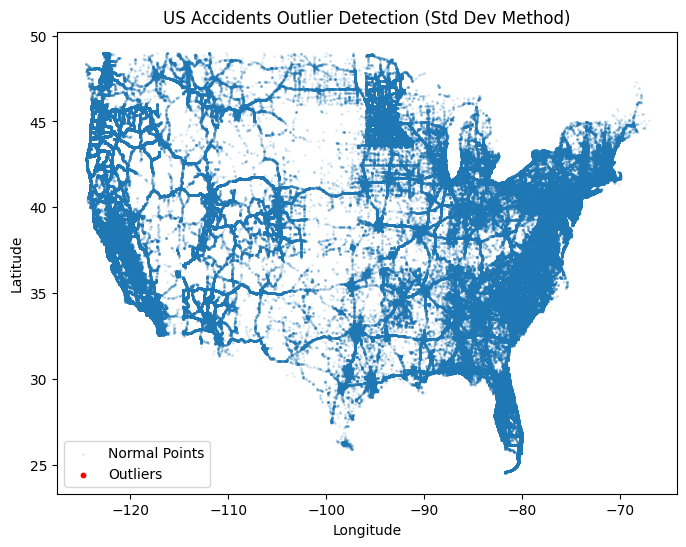

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# Convert to pandas Series before plotting
df_lat_pandas = df['Start_Lat'].to_pandas() if isinstance(df, cudf.DataFrame) else df['Start_Lat']
df_lng_pandas = df['Start_Lng'].to_pandas() if isinstance(df, cudf.DataFrame) else df['Start_Lng']
outliers_lat_pandas = outliers['Start_Lat'].to_pandas() if isinstance(outliers, cudf.DataFrame) else outliers['Start_Lat']
outliers_lng_pandas = outliers['Start_Lng'].to_pandas() if isinstance(outliers, cudf.DataFrame) else outliers['Start_Lng']


# Plot normal points
plt.scatter(df_lng_pandas, df_lat_pandas, s=1, alpha=0.1, label="Normal Points")

# Plot outliers
plt.scatter(outliers_lng_pandas, outliers_lat_pandas, s=10, color='red', label="Outliers")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("US Accidents Outlier Detection (Std Dev Method)")
plt.legend()
plt.show()